# IMPORT LIBRARIES

In [1]:
import eli5
import shap
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib
import xgboost
import datetime
from dateutil.relativedelta import relativedelta, MO
plt.style.use('ggplot')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.classifier import ClassBalance, ClassPredictionError, ConfusionMatrix, ClassificationReport, ROCAUC
from yellowbrick.features import FeatureImportances
from sklearn.preprocessing import RobustScaler

C:\Users\eortiz\Anaconda3\envs\CupoIntegral\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\eortiz\Anaconda3\envs\CupoIntegral\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corres

# CRISP-DM

# 1. BUSINESS UNDERSTANDING & 2. DATA UNDERSTANDING

Did 1. and 2.  in tandem cause help using the data to help us arrive at our questions of interest. 

### CALENDAR

In [2]:
#Import data
calendar = pd.read_csv('C:/Users/eortiz/Downloads/PROYECTO_COURSERA/calendar.csv', sep=',',decimal='.')

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [3]:
calendar.head(1000) #First view

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
...,...,...,...,...
995,6976,2017-05-22,t,$65.00
996,6976,2017-05-21,t,$65.00
997,6976,2017-05-20,t,$65.00
998,6976,2017-05-19,t,$65.00


In [4]:
# Convert data 'price' to numeric 
calendar['price'] = calendar['price'].str.replace("$",'')
calendar['price'] = calendar['price'].str.replace(",",'')
calendar['price']=calendar['price'].astype('float64')
calendar.head(1000)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
...,...,...,...,...
995,6976,2017-05-22,t,65.0
996,6976,2017-05-21,t,65.0
997,6976,2017-05-20,t,65.0
998,6976,2017-05-19,t,65.0


In [5]:
# Do more intuitive the data
calendar = calendar.replace(to_replace="t", value=1)
calendar = calendar.replace(to_replace="f", value=0)
calendar["available"].value_counts()

0    665853
1    643037
Name: available, dtype: int64

In [6]:
# Calculate the usage in a year
calendar_use=calendar.groupby(['listing_id']).sum()['available'].reset_index()
calendar_use['usage_percentage']=((365-calendar_use['available'])/365)*100
calendar_use.describe()

,listing_id,available,usage_percentage
count,3.585000e+03,3585.000000,3585.000000
mean,8.440875e+06,179.368759,50.857874
std,4.500787e+06,142.126858,38.938865
min,3.353000e+03,0.000000,0.000000
25%,4.679319e+06,19.000000,10.958904
50%,8.577620e+06,179.000000,50.958904
75%,1.278953e+07,325.000000,94.794521
max,1.493346e+07,365.000000,100.000000


In [7]:
# group by month register
calendar['date'] = calendar['date'].str[:-3]
calendar['date'] = pd.to_datetime(calendar['date'],format="%Y-%m-%d")
calendar["date"].value_counts().sort_index()

2016-09-01     89650
2016-10-01    111166
2016-11-01    107580
2016-12-01    111166
2017-01-01    111166
2017-02-01    100408
2017-03-01    111166
2017-04-01    107580
2017-05-01    111166
2017-06-01    107580
2017-07-01    111166
2017-08-01    111166
2017-09-01     17930
Name: date, dtype: int64

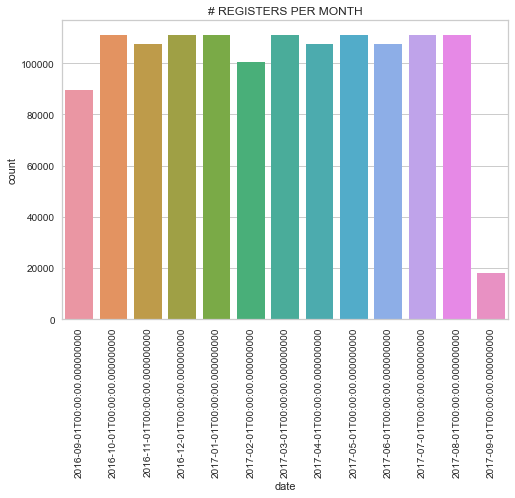

In [10]:
#See the searching behavior in Boston
bar_plot = sns.countplot(calendar['date'])
bar_plot.set_title('# REGISTERS PER MONTH')
plt.xticks(rotation=90)
plt.show()

In [9]:
#number of rents per month
calendar.query("available == '1' ").groupby(['date']).sum()['available'].reset_index()

,date,available
0,2016-09-01,24401
1,2016-10-01,46345
2,2016-11-01,58888
3,2016-12-01,60997
4,2017-01-01,63181
5,2017-02-01,56810
6,2017-03-01,55181
7,2017-04-01,51382
8,2017-05-01,53600
9,2017-06-01,52731


In [12]:
#new data frame just when the property is available in calendar
av_month=calendar[calendar['available'] ==1]

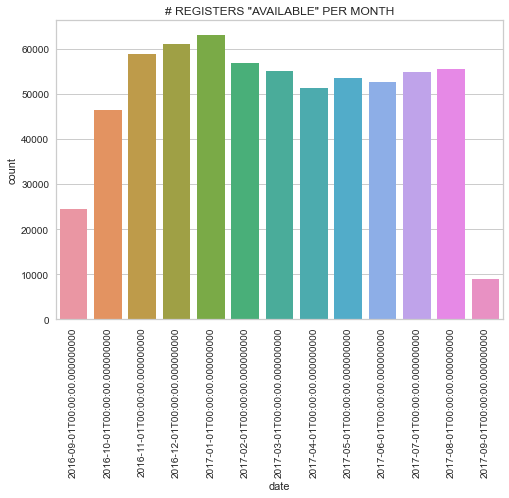

In [13]:
#See the booking behavior in Boston
bar_plot = sns.countplot(av_month['date'])
bar_plot.set_title('# REGISTERS "AVAILABLE" PER MONTH')
plt.xticks(rotation=90)
plt.show()

In [14]:
#average of price rented houses,apt, etc
salary_mean = calendar.groupby(['date']).mean()['price'].reset_index() #.sort_values() 
salary_mean

,date,price
0,2016-09-01,252.677308
1,2016-10-01,233.416248
2,2016-11-01,202.924416
3,2016-12-01,192.601915
4,2017-01-01,182.799671
5,2017-02-01,180.961028
6,2017-03-01,181.818742
7,2017-04-01,197.252890
8,2017-05-01,193.712295
9,2017-06-01,196.535302


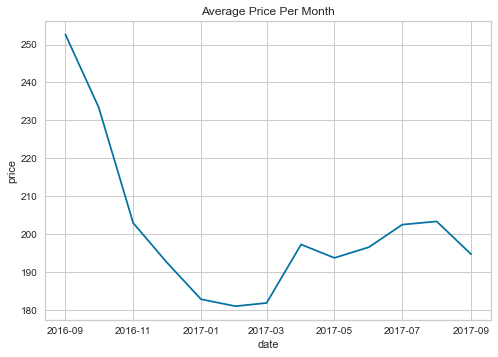

In [16]:
#Price-date plot
line_plot=sns.lineplot(data=salary_mean, x="date", y="price")
line_plot.set_title('Average Price Per Month')
plt.show()

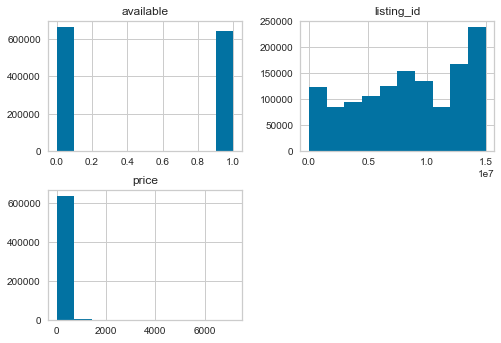

In [14]:
calendar.hist();

### LISTINGS

In [15]:
#IMPORTAR DATOS
listings = pd.read_csv('C:/Users/ML/Downloads/PROYECTO_COURSERA/listings.csv')

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [16]:
#Drop columns with higher missing columns
most_missing_cols = set(listings.columns[listings.isnull().mean() >0.80].tolist())
most_missing_cols

for col in most_missing_cols:
        del listings[col]

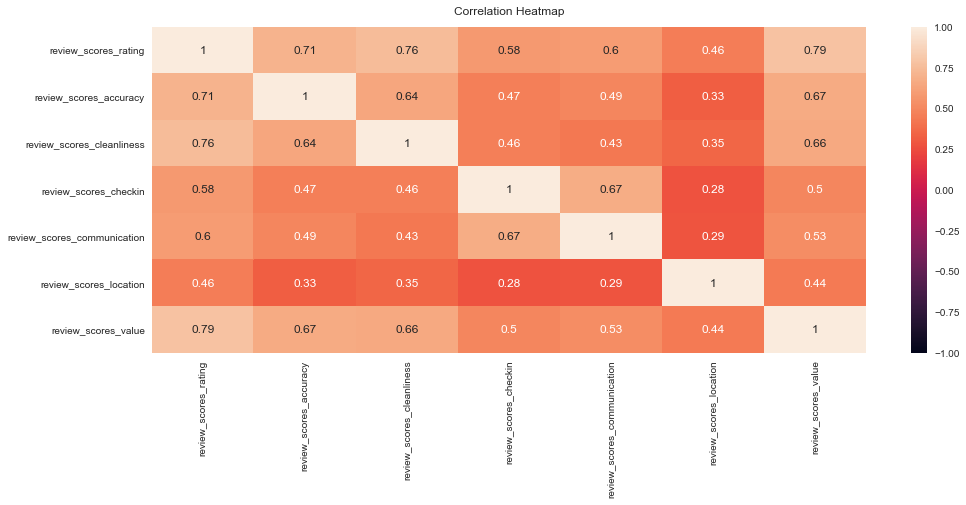

In [17]:
#Select all review variables for see the correlation
desired_columns = ['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                   'review_scores_communication' ,'review_scores_location' ,'review_scores_value']                                
subset = listings[desired_columns]
#Considering that 7 desired columns have around 2675 non-nulls rows is more easy delete the rows that are full empty cause now just want to the correlation, not preparing the data

subset = subset.dropna(how='any')

subset.shape

plt.figure(figsize=(16, 6))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(subset.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [18]:
#select variables that are usefull to answer the question 
usefull_col={'id','house_rules','host_response_time','host_response_rate','host_since','host_acceptance_rate','host_is_superhost',
          'host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms','bedrooms',
           'beds','price','extra_people','number_of_reviews','reviews_per_month','review_scores_rating','review_scores_checkin'
           ,'review_scores_location'} #select intuitive variables that are usefull

listings_df = listings[usefull_col]
listings_df.head()

,host_acceptance_rate,number_of_reviews,host_identity_verified,house_rules,extra_people,review_scores_checkin,host_is_superhost,accommodates,review_scores_rating,host_response_rate,...,property_type,room_type,review_scores_location,host_response_time,id,bedrooms,reviews_per_month,bathrooms,price,neighbourhood_cleansed
0,NaN,0,f,Clean up and treat the home the way you'd like...,$0.00,NaN,f,4,NaN,NaN,...,House,Entire home/apt,NaN,NaN,12147973,2.0,NaN,1.5,$250.00,Roslindale
1,100%,36,t,Pet friendly but please confirm with me if the...,$0.00,10.0,f,2,94.0,100%,...,Apartment,Private room,9.0,within an hour,3075044,1.0,1.30,1.0,$65.00,Roslindale
2,88%,41,t,"I encourage you to use my kitchen, cooking and...",$20.00,10.0,t,2,98.0,100%,...,Apartment,Private room,9.0,within a few hours,6976,1.0,0.47,1.0,$65.00,Roslindale
3,50%,1,f,- The bathroom and house are shared so please ...,$25.00,10.0,f,4,100.0,100%,...,House,Private room,10.0,within a few hours,1436513,1.0,1.00,1.0,$75.00,Roslindale
4,100%,29,t,"Please no smoking in the house, porch or on th...",$0.00,10.0,t,2,99.0,100%,...,House,Private room,9.0,within an hour,7651065,1.0,2.25,1.5,$79.00,Roslindale


### reviews

In [19]:
#IMPORTAR DATOS
reviews = pd.read_csv('C:/Users/ML/Downloads/PROYECTO_COURSERA/reviews.csv')
reviews['date'] = reviews['date'].str[:-3]
#reviews =reviews.set_index(['id'])
reviews=reviews.drop(labels='reviewer_id',axis=1)
reviews=reviews.drop(labels='reviewer_name',axis=1)

reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   listing_id  68275 non-null  int64 
 1   id          68275 non-null  int64 
 2   date        68275 non-null  object
 3   comments    68222 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.1+ MB


In [20]:
reviews.head()

,listing_id,id,date,comments
0,1178162,4724140,2013-05,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05,Great location for both airport and city - gre...
2,1178162,5003196,2013-06,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06,Great location. Just 5 mins walk from the Airp...


In [21]:
cous_ed_vals = reviews["comments"].value_counts().reset_index()
cous_ed_vals

,index,comments
0,The host canceled this reservation the day bef...,112
1,The host canceled this reservation 3 days befo...,29
2,The host canceled this reservation 2 days befo...,28
3,The reservation was canceled the day before ar...,28
4,The host canceled this reservation 5 days befo...,28
...,...,...
67306,"Roger is the perfect host, and his place is in...",1
67307,L'hote a été très accueillante et a fait en so...,1
67308,Gustavo was absolutely wonderful and the room ...,1
67309,The first thing we noticed as we arrived was h...,1


In [22]:
cous_ed_vals.rename(columns={'index':'comments','comments':'count'}, inplace=True)
cous_ed_vals.head()

,comments,count
0,The host canceled this reservation the day bef...,112
1,The host canceled this reservation 3 days befo...,29
2,The host canceled this reservation 2 days befo...,28
3,The reservation was canceled the day before ar...,28
4,The host canceled this reservation 5 days befo...,28


#                                 3.  PREPARE DATA

This is commonly denoted as 80% of the process

In [23]:
# Merge the two data frames that i build with calendar data and listings data
listings_df=listings_df.set_index(['id'])
calendar_use=calendar_use.set_index(['listing_id'])

df = pd.merge(listings_df,calendar_use,left_index=True,right_index=True)
df.shape

(3585, 23)

In [24]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 12147973 to 14504422
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    3114 non-null   object 
 1   number_of_reviews       3585 non-null   int64  
 2   host_identity_verified  3585 non-null   object 
 3   house_rules             2393 non-null   object 
 4   extra_people            3585 non-null   object 
 5   review_scores_checkin   2765 non-null   float64
 6   host_is_superhost       3585 non-null   object 
 7   accommodates            3585 non-null   int64  
 8   review_scores_rating    2772 non-null   float64
 9   host_response_rate      3114 non-null   object 
 10  host_since              3585 non-null   object 
 11  beds                    3576 non-null   float64
 12  property_type           3582 non-null   object 
 13  room_type               3585 non-null   object 
 14  review_scores_location  2763 

In [25]:
df.head()

,host_acceptance_rate,number_of_reviews,host_identity_verified,house_rules,extra_people,review_scores_checkin,host_is_superhost,accommodates,review_scores_rating,host_response_rate,...,room_type,review_scores_location,host_response_time,bedrooms,reviews_per_month,bathrooms,price,neighbourhood_cleansed,available,usage_percentage
12147973,NaN,0,f,Clean up and treat the home the way you'd like...,$0.00,NaN,f,4,NaN,NaN,...,Entire home/apt,NaN,NaN,2.0,NaN,1.5,$250.00,Roslindale,0,100.000000
3075044,100%,36,t,Pet friendly but please confirm with me if the...,$0.00,10.0,f,2,94.0,100%,...,Private room,9.0,within an hour,1.0,1.30,1.0,$65.00,Roslindale,359,1.643836
6976,88%,41,t,"I encourage you to use my kitchen, cooking and...",$20.00,10.0,t,2,98.0,100%,...,Private room,9.0,within a few hours,1.0,0.47,1.0,$65.00,Roslindale,319,12.602740
1436513,50%,1,f,- The bathroom and house are shared so please ...,$25.00,10.0,f,4,100.0,100%,...,Private room,10.0,within a few hours,1.0,1.00,1.0,$75.00,Roslindale,98,73.150685
7651065,100%,29,t,"Please no smoking in the house, porch or on th...",$0.00,10.0,t,2,99.0,100%,...,Private room,9.0,within an hour,1.0,2.25,1.5,$79.00,Roslindale,334,8.493151


#### PREPARING VARIABLES

In [26]:
### price
df['price'] = df['price'].str.replace("$",'')
df['price'] = df['price'].str.replace(",",'')
df['price'] = df['price'].astype('float64')
### extra people
df['extra_people'] = df['extra_people'].str.replace("$",'')
df['extra_people'] = df['extra_people'].str.replace(",",'')
df['extra_people'] = df['extra_people'].astype('float64')
### host_response_rate
df["host_response_rate"]=df["host_response_rate"].replace(np.NaN,'0%')
df['host_response_rate'] = df['host_response_rate'].str.replace("%",'')
df['host_response_rate'] = df['host_response_rate'].astype('int64')
### review_scores_rating
df["review_scores_rating"]=df["review_scores_rating"].replace(np.NaN,0)
df['review_scores_rating'] = df['review_scores_rating'].astype('int64')
### beds
df["beds"]=df["beds"].replace(np.NaN,1)
df['beds'] = df['beds'].astype('int64')
## bedrooms
df["bedrooms"]=df["bedrooms"].replace(np.NaN,1)
df['bedrooms'] = df['bedrooms'].astype('int64')
## review_scores_checkin
df["review_scores_checkin"]=df["review_scores_checkin"].replace(np.NaN,0)
df['review_scores_checkin'] = df['review_scores_checkin'].astype('int64')
## bathrooms
df["bathrooms"]=df["bathrooms"].replace(np.NaN,0)
df['bathrooms'] = df['bathrooms'].astype('int64')
## host_response_time
df["host_response_time"]=df["host_response_time"].replace(np.NaN,'doesn´t respond')
## property_type
df = df[pd.notnull(df['property_type'])]
## reviews_per_month
df["reviews_per_month"]=df["reviews_per_month"].replace(np.NaN,0.0)
df['reviews_per_month'] = df['reviews_per_month'].astype('float64')
## host_acceptance_rate
df["host_acceptance_rate"]=df["host_acceptance_rate"].replace(np.NaN,'0%')
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%",'')
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype('int64')
## house rules
df=df.drop(labels='house_rules',axis=1)
## reviews_per_month
df["review_scores_location"]=df["review_scores_location"].replace(np.NaN,0.0)
df['review_scores_location'] = df['review_scores_location'].astype('float64')

In [27]:
# Made sure that we dont have null value in columns
df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3582 entries, 12147973 to 14504422
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    3582 non-null   int64  
 1   number_of_reviews       3582 non-null   int64  
 2   host_identity_verified  3582 non-null   object 
 3   extra_people            3582 non-null   float64
 4   review_scores_checkin   3582 non-null   int64  
 5   host_is_superhost       3582 non-null   object 
 6   accommodates            3582 non-null   int64  
 7   review_scores_rating    3582 non-null   int64  
 8   host_response_rate      3582 non-null   int64  
 9   host_since              3582 non-null   object 
 10  beds                    3582 non-null   int64  
 11  property_type           3582 non-null   object 
 12  room_type               3582 non-null   object 
 13  review_scores_location  3582 non-null   float64
 14  host_response_time      3582 

In [28]:
#Adapt host_since variable to put in to the model
a = pd.to_datetime('2017-09-30',format="%Y-%m-%d") #last date of data
df['host_since'] = pd.to_datetime(df['host_since'],format="%Y-%m-%d")

df['host_since'] =  a-df['host_since'] #days of difference
df['host_since'] = df['host_since'].dt.days #pass to numeric
df['host_since'] = round((df['host_since']/365),1) #pass #days to years
print(df['host_since'])

12147973    2.5
3075044     5.3
6976        8.4
1436513     4.4
7651065     3.4
           ... 
8373729     3.2
14844274    2.2
14585486    3.7
14603878    1.3
14504422    2.1
Name: host_since, Length: 3582, dtype: float64


In [29]:
numerical= df.select_dtypes(include=['float64', 'int64']).columns.to_list() # get the numerical feature names
categorical = df.select_dtypes(include=['object']).columns.to_list() # get the categorical feature names

In [30]:
len(categorical)

6

### NUMERICAL

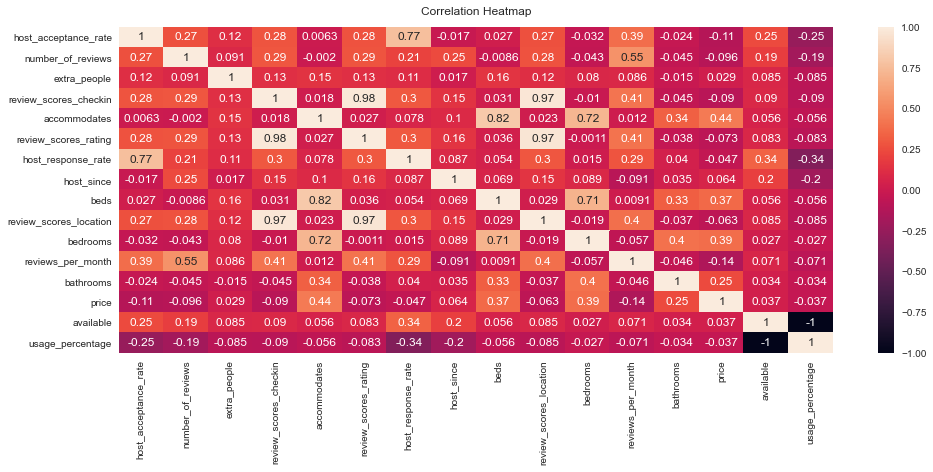

In [31]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df[numerical].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

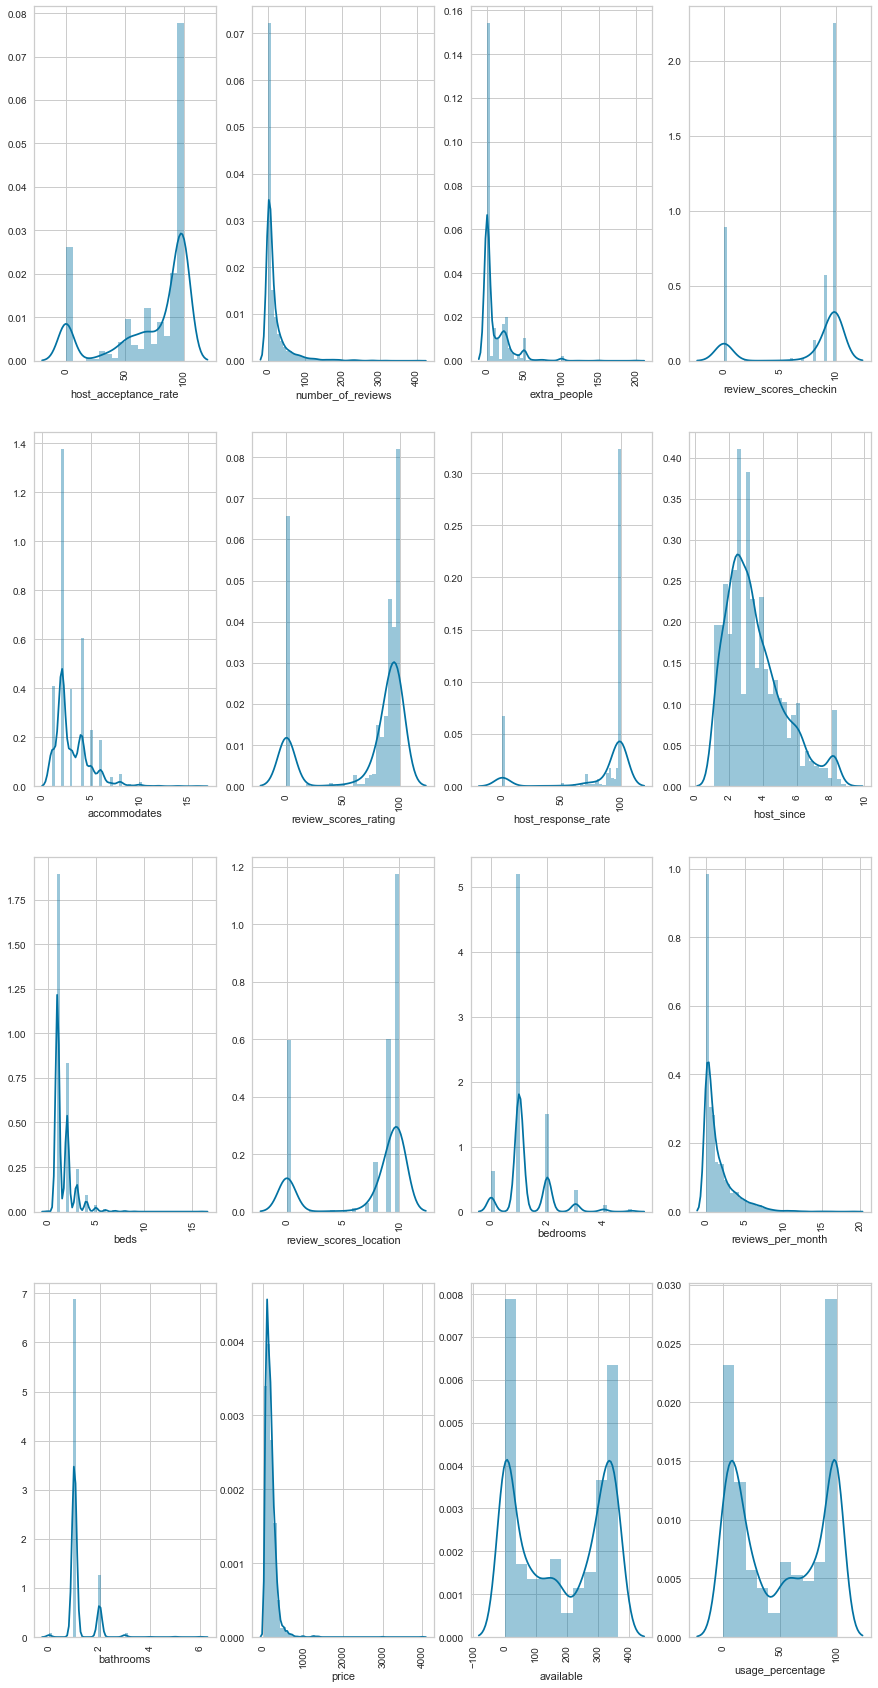

In [32]:
fig, ax = plt.subplots(4, 4, figsize=(15, 30))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.distplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

### CATEGORICAL

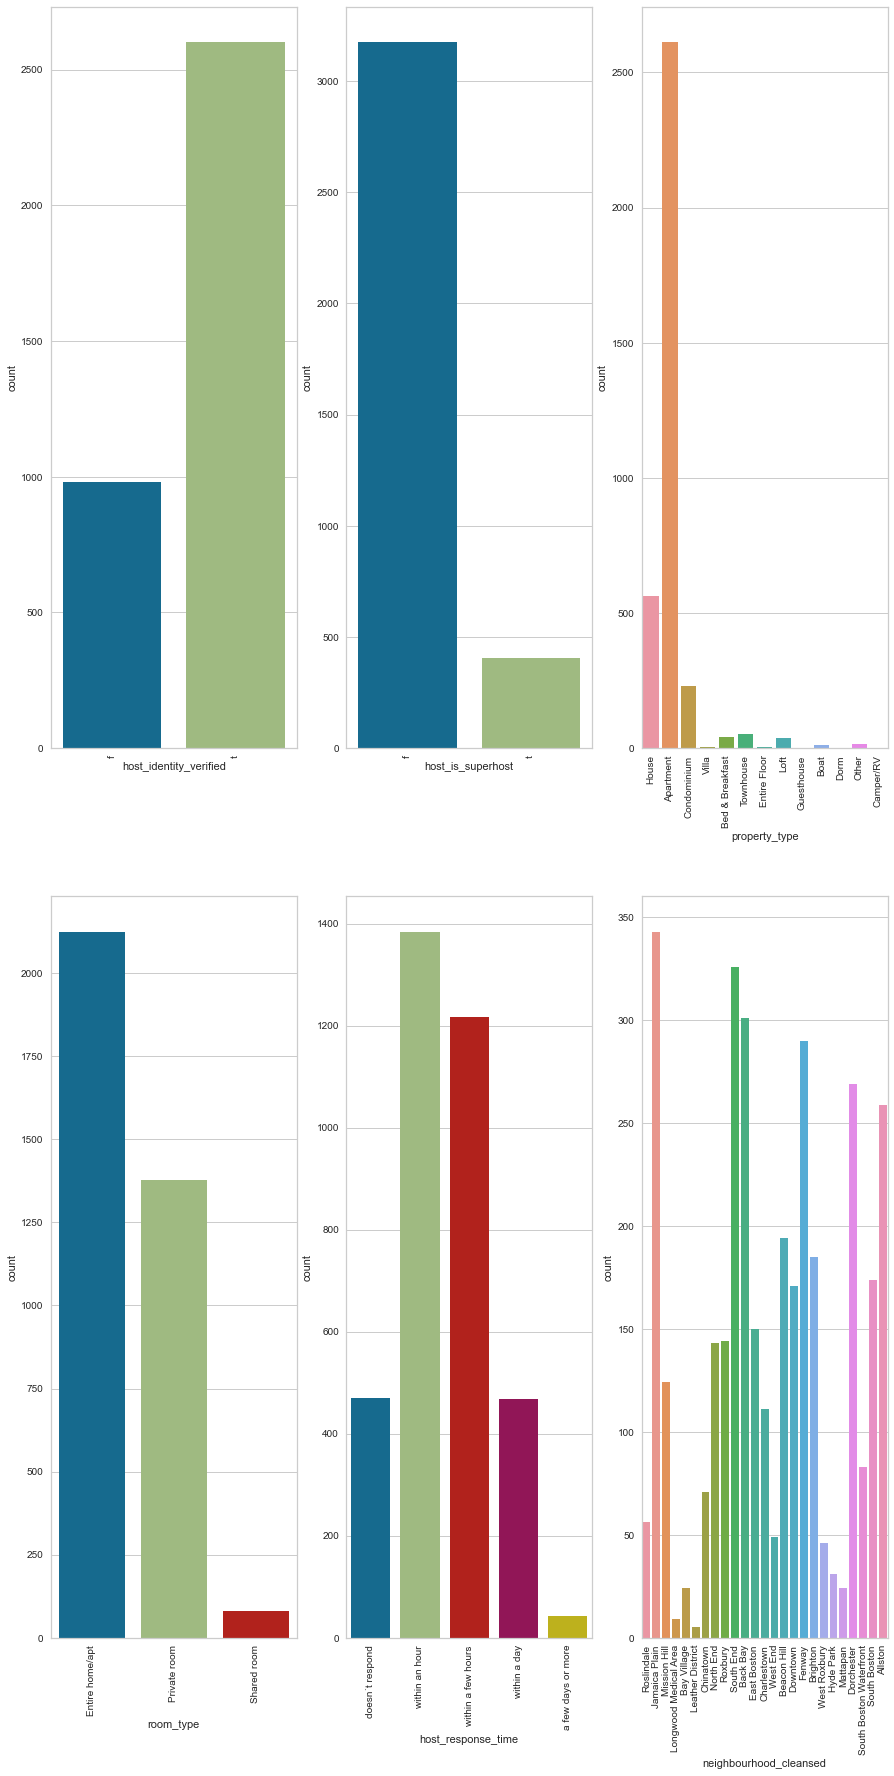

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(15, 30))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

###  THE FINAL DATABASE

In [34]:
#drop high correlation 
df=df.drop(labels="available", axis=1) #used to build y
df=df.drop(labels="review_scores_checkin", axis=1) #review score ratings
df=df.drop(labels="review_scores_location", axis=1) #review score ratings
df=df.drop(labels="beds", axis=1) #accommodates
df=df.drop(labels="bedrooms", axis=1) #accommodates
df=df.drop(labels="host_response_rate", axis=1) #host_acceptance_rate

In [35]:
#DROP AFTER FIRTS RUN MODEL(ambiguous SHAP VALUES)
df=df.drop(labels="host_is_superhost", axis=1)

In [36]:
#Define  response variable
df["usage_percentage"]=df["usage_percentage"].apply(lambda x: 1 if x>=50 else 0)

In [37]:
# Create the X feature matrix and the y target vector
X = df.drop(labels="usage_percentage", axis=1)
y = df["usage_percentage"]
# the only step necessary to be done outside of pipeline
col = pd.Categorical(y)
y = pd.Series(col.codes)
# global variables
seed = 248

In [38]:
y

0       1
1       0
2       0
3       1
4       0
       ..
3577    0
3578    0
3579    1
3580    0
3581    1
Length: 3582, dtype: int8

In [39]:
X['neighbourhood_cleansed'].value_counts()

Jamaica Plain              343
South End                  326
Back Bay                   301
Fenway                     290
Dorchester                 269
Allston                    259
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   171
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

### PIPELINE

In [34]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    '''
    extracts and returns the pandas dataset with only those columns whose names were passed to it as an argument during 
    its initialization
       
    Parameters
    ----------
        BaseEstimator :  ensures that all we need to do is write our fit and transform methods and we get fit_transform for free
        TransformerMixin : we get get_params and set_params for free 
    '''
   #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]

In [32]:
# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
       '''
    extracts and returns the pandas dataset with only those columns whose names were passed to it as an argument during
    its initialization, the transform method for categorical features is what we’re really writing to make the transformer
    do what we need it to do
       
    Parameters
    ----------
        BaseEstimator :  ensures that all we need to do is write our fit and transform methods and we get fit_transform for free
        TransformerMixin : we get get_params and set_params for free 
    '''
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    ''' Modify data to reduce category level by grouping'''
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            
            # Two many category level, convert just US and Non-US
            df.loc[df['room_type']=='Entire home/apt','room_type'] = 'ENTIRE'
            df.loc[df['room_type']=='Private room','room_type'] = 'PRIVATE'
            df.loc[df['room_type']=='Shared room','room_type'] = 'SHARED'
            
            df.loc[df['property_type']=='Apartment','property_type'] = 'Apartment'
            df.loc[df['property_type']=='Loft','property_type'] = 'Apartment'
            df.loc[df['property_type']=='Entire Floor','property_type'] = 'Apartment'
            df.loc[df['property_type']=='House','property_type'] = 'House'
            df.loc[df['property_type']=='Guesthouse','property_type'] = 'House'
            df.loc[df['property_type']=='Townhouse','property_type'] = 'House'
            df.loc[df['property_type']=='Condominium','property_type'] = 'Condominium'  
            df.loc[df['property_type']=='Villa','property_type'] = 'Condominium' 
            df.loc[df['property_type']=='Other','property_type'] = 'Other'
            df.loc[df['property_type']=='Bed & Breakfast','property_type'] = 'Other'
            df.loc[df['property_type']=='Boat','property_type'] = 'Other'
            df.loc[df['property_type']=='Camper/RV','property_type'] = 'Other'
            df.loc[df['property_type']=='Dorm','property_type'] = 'Other'
            
            df.loc[df['host_response_time']=='within an hour','host_response_time'] = 'SAME DAY'
            df.loc[df['host_response_time']=='within a few hours','host_response_time'] = 'SAME DAY'
            df.loc[df['host_response_time']=='within a day','host_response_time'] = 'PLUS ONE DAY'
            df.loc[df['host_response_time']=='a few days or more','host_response_time'] = 'PLUS ONE DAY'
            df.loc[df['host_response_time']=='doesn´t respond','host_response_time'] = 'DOESN´T RESPOND'
           
        # convert columns to categorical
        for name in df.columns.to_list():
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        return df

In [41]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()
numerical_features = numerical_features+X.select_dtypes("float64").columns.to_list()

# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer())
]
# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', RobustScaler()),
]
# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

In [42]:
pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

In [43]:
columnas=categorical_features + numerical_features #Labels for XG Boost
columnas

['host_identity_verified',
 'property_type',
 'room_type',
 'host_response_time',
 'neighbourhood_cleansed',
 'host_acceptance_rate',
 'number_of_reviews',
 'accommodates',
 'review_scores_rating',
 'bathrooms',
 'extra_people',
 'host_since',
 'reviews_per_month',
 'price']

# 4. MODEL DATA

We were finally able to model the data

### MODEL EXECUTION

In [44]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

In [45]:
preprocessing_pipeline.fit(X_train)

FeatureUnion(n_jobs=None,
             transformer_list=[('categorical_pipeline',
                                Pipeline(memory=None,
                                         steps=[('cat_selector',
                                                 FeatureSelector(feature_names=['host_identity_verified',
                                                                                'property_type',
                                                                                'room_type',
                                                                                'host_response_time',
                                                                                'neighbourhood_cleansed'])),
                                                ('cat_transformer',
                                                 CategoricalTransformer(new_features=True))],
                                         verbose=False)),
                               ('numerical_pipeline',
                  

#### XGBOOST

In [46]:
# we pass the preprocessing pipeline as a step to the full pipeline
new_X_train = preprocessing_pipeline.transform(X_train)
new_X_train = pd.DataFrame(new_X_train, columns=columnas)

new_X_train.columns.tolist()

['host_identity_verified',
 'property_type',
 'room_type',
 'host_response_time',
 'neighbourhood_cleansed',
 'host_acceptance_rate',
 'number_of_reviews',
 'accommodates',
 'review_scores_rating',
 'bathrooms',
 'extra_people',
 'host_since',
 'reviews_per_month',
 'price']

In [47]:
# create a default XGBoost classifier
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
       "learning_rate": [0.1,0.01],
    "colsample_bytree": [0.2, 0.4],
    "subsample": [0.2, 0.4],
    "max_depth": [4],
    "n_estimators": [1000],
    "reg_lambda": [1,1.5],
    "gamma": [0.4,1],
}
scoring={'AUC': 'roc_auc', 
         'Accuracy': make_scorer(accuracy_score)}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
best_xgb = grid.fit(new_X_train,y_train)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.


In [48]:
xgb_model=best_xgb.best_estimator_ #guardar xgboost

In [49]:
# we pass the preprocessing pipeline as a step to the full pipeline for test
new_X_test = preprocessing_pipeline.transform(X_test) #transform
new_X_test = pd.DataFrame(new_X_test, columns=columnas)

new_X_test.columns.tolist()

['host_identity_verified',
 'property_type',
 'room_type',
 'host_response_time',
 'neighbourhood_cleansed',
 'host_acceptance_rate',
 'number_of_reviews',
 'accommodates',
 'review_scores_rating',
 'bathrooms',
 'extra_people',
 'host_since',
 'reviews_per_month',
 'price']

In [50]:
#test
pred_test = xgb_model.predict(new_X_test)
pred_train = xgb_model.predict(new_X_train) 
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8081372157957718
Test Accuraccy:  0.7153488372093023

Confusion Matrix:
[[368 148]
 [158 401]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71       516
           1       0.73      0.72      0.72       559

    accuracy                           0.72      1075
   macro avg       0.72      0.72      0.72      1075
weighted avg       0.72      0.72      0.72      1075



# 5. RESULTS

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
could not determine class_counts_ from previously fitted classifier


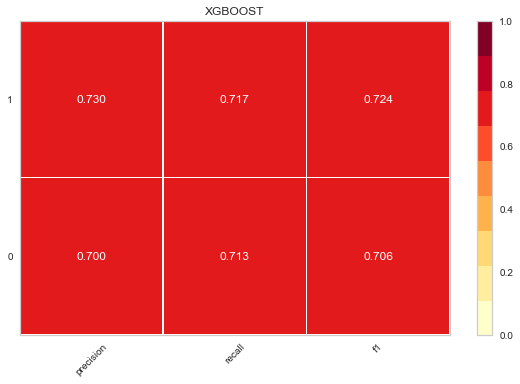

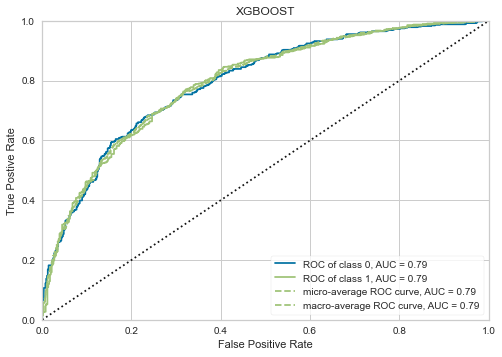

In [51]:
##Codigo Report

viz =ClassificationReport(xgb_model,title="XGBOOST")
viz.score(new_X_test, y_test)
viz.show()

##ROCAUC

viz =ROCAUC(xgb_model,title="XGBOOST")
viz.score(new_X_test, y_test)
viz.show()


The ROC CURVE have a good perfomance and the AUC metric is 0.79,It is also good.

Now that we know the model have a good perfomance , it´s time to understand what I need if would like to put in rent a property in Airbnb with success.

###  FEATURES PLOTS


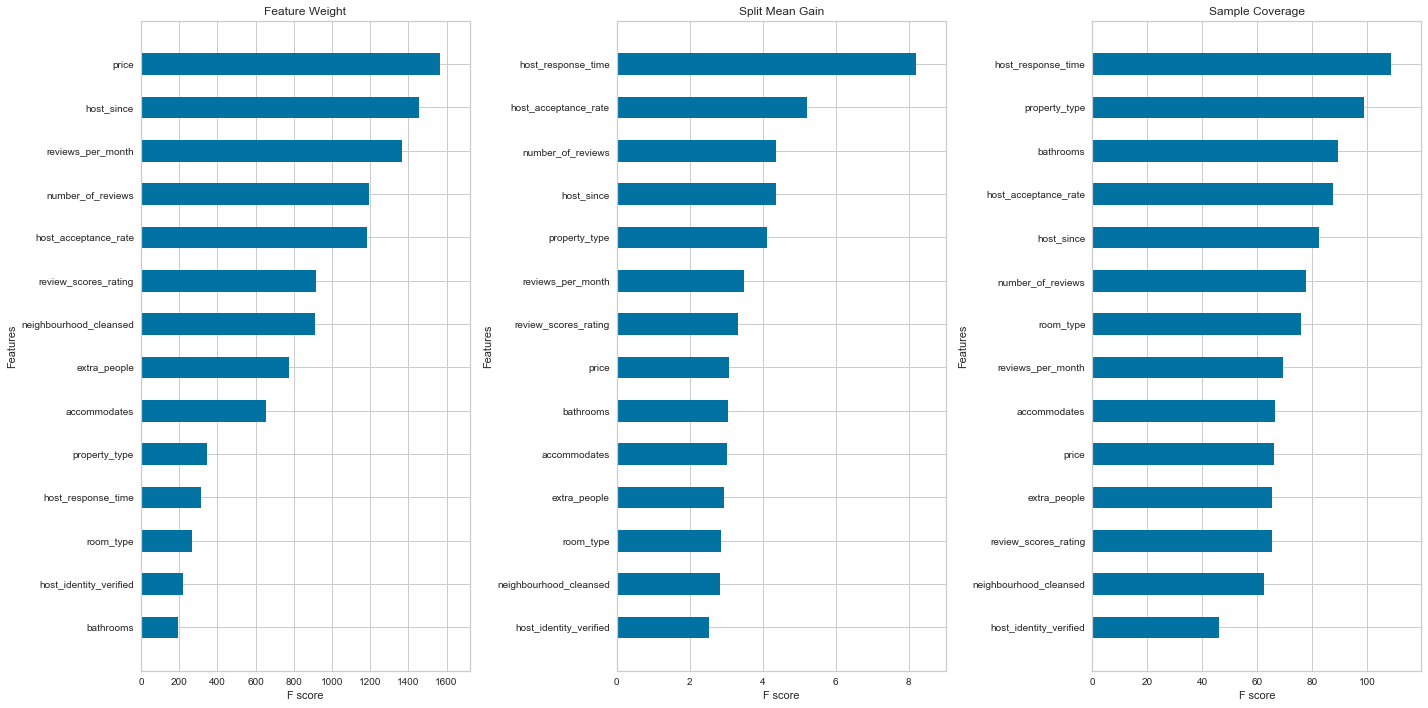

In [52]:
# saving the feature names to the model
xgb_model.get_booster().feature_names = columnas
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(20,10))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgb_model, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgb_model,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xgb_model,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

## SHAP VALUES

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [53]:
def_model=xgb_model

shap.initjs()
explainer=shap.TreeExplainer(def_model)
shap_values=explainer.shap_values(new_X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### IMPORTANCE

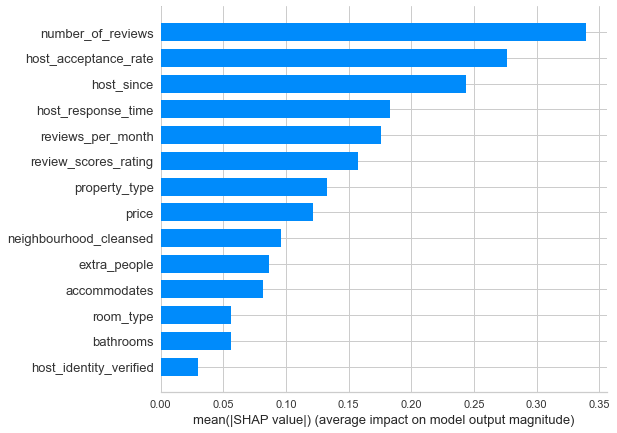

In [54]:
shap.summary_plot(shap_values,new_X_test,plot_type="bar")

The plot show us in descent order feature importance of the features that mostly impact the probabilitys in the XGBoost model. Then number_of_reviews is one of the most important features and his magnitude impact highly the model. The opposite case is host_identify_verified, this feature magnitude impact lowly the model

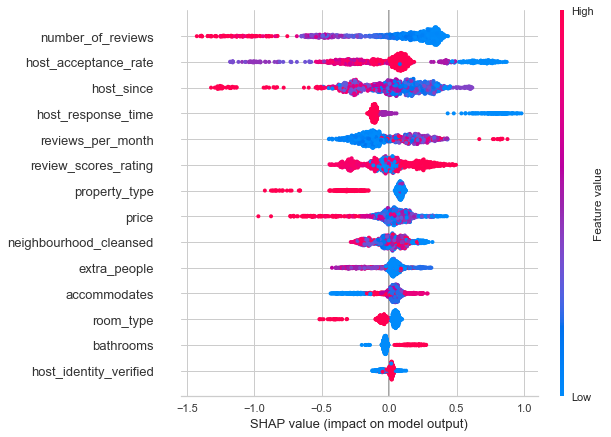

In [55]:
shap.summary_plot(shap_values, new_X_test)

This plot let us know how the feature value and sign (+,-) impact the model increasen or decreasen the probability in the target feature . In the perfect plot, we wont see purple color in any feature, however the features achieve their purpose of discrimate between >50% and <50% .

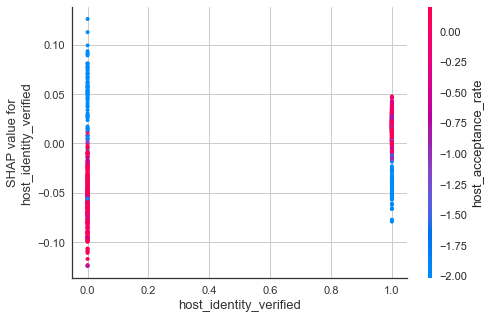

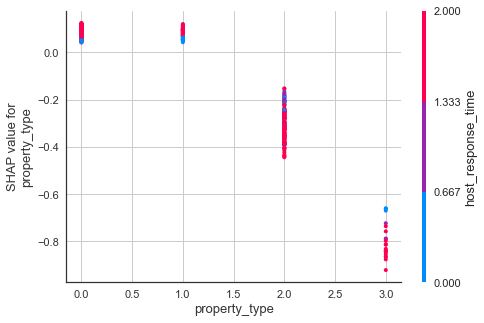

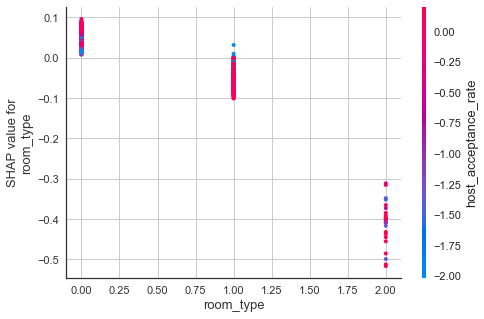

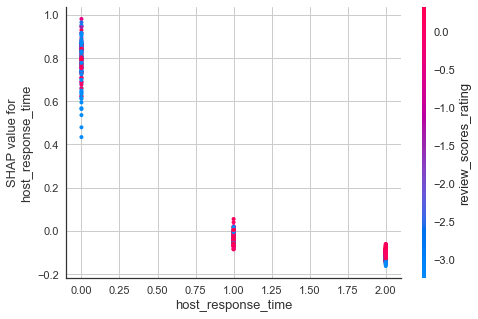

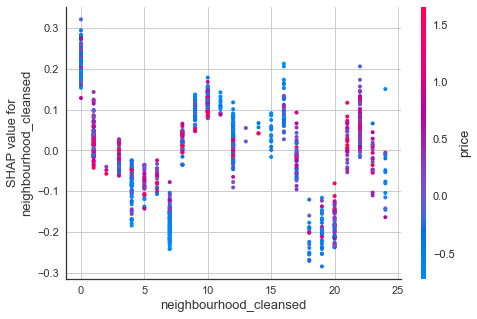

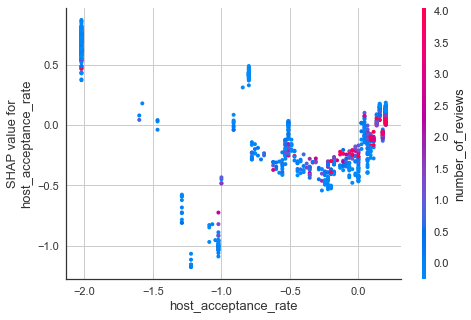

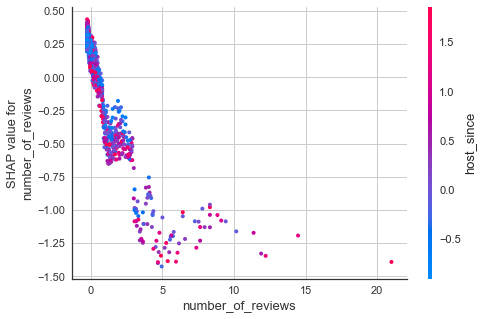

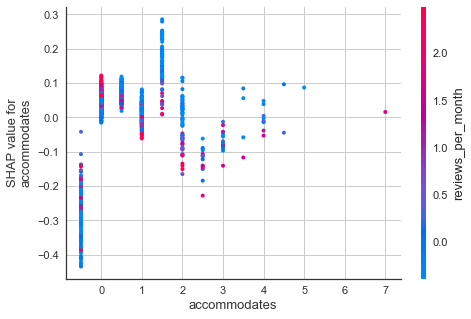

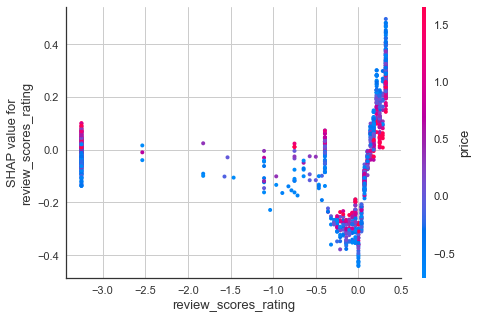

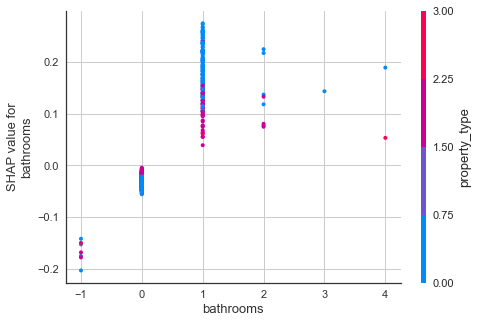

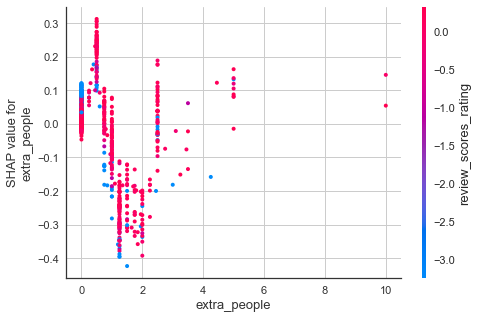

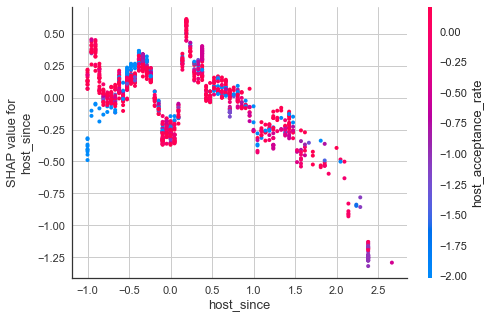

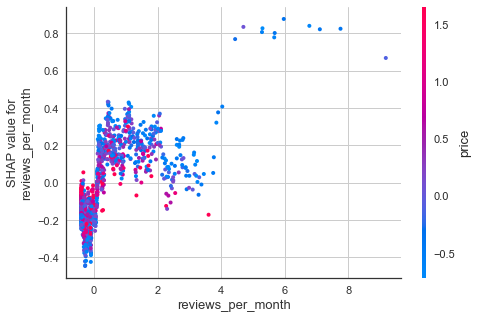

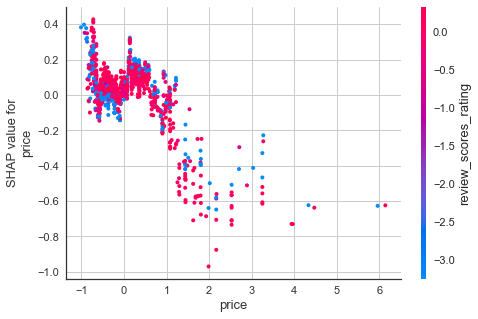

In [56]:
for name in new_X_train.columns:
    shap.dependence_plot(name, shap_values, new_X_test, display_features=new_X_test)